In [10]:
library(Seurat)
library(dplyr)
library(ComplexHeatmap)
library(circlize)
library(SeuratDisk)
library(Seurat)
library(dplyr)
library(ggplot2)
library(ComplexHeatmap)
library(circlize)
library(reshape2)

In [11]:
# ---------------------------------------------------------
# 0. Load your merged object
# ---------------------------------------------------------
obj <- readRDS("/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/GSE228421_integrated_annotated.rds")


In [12]:
DefaultAssay(obj) <- "RNA"

In [13]:
str(obj)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 3
  .. ..$ RNA       :Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 40
  .. .. .. .. ..$ counts.1 :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:16105274] 30 32 45 86 97 104 170 208 238 254 ...
  .. .. .. .. .. .. ..@ p       : int [1:10505] 0 1531 1927 2682 3191 4729 6007 9366 10840 11631 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 36611 10504
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:16105274] 1 1 2 1 2 1 2 1 2 1 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ counts.2 :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:12768561] 29 51 59 79 83 86 170 173 204 208 ...
  .. .. .. .. .. .. ..@ p       : int [1:7453] 0 1805 2258 3

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Scaled Expression (0–1)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Scaled Expression (0–1)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Scaled Expression (0–1)' in 'mbcsToSbcs': dot substituted for <93>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Scaled Expression (0–1)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Scaled Expression (0–1)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Scaled Expression (0–1)'

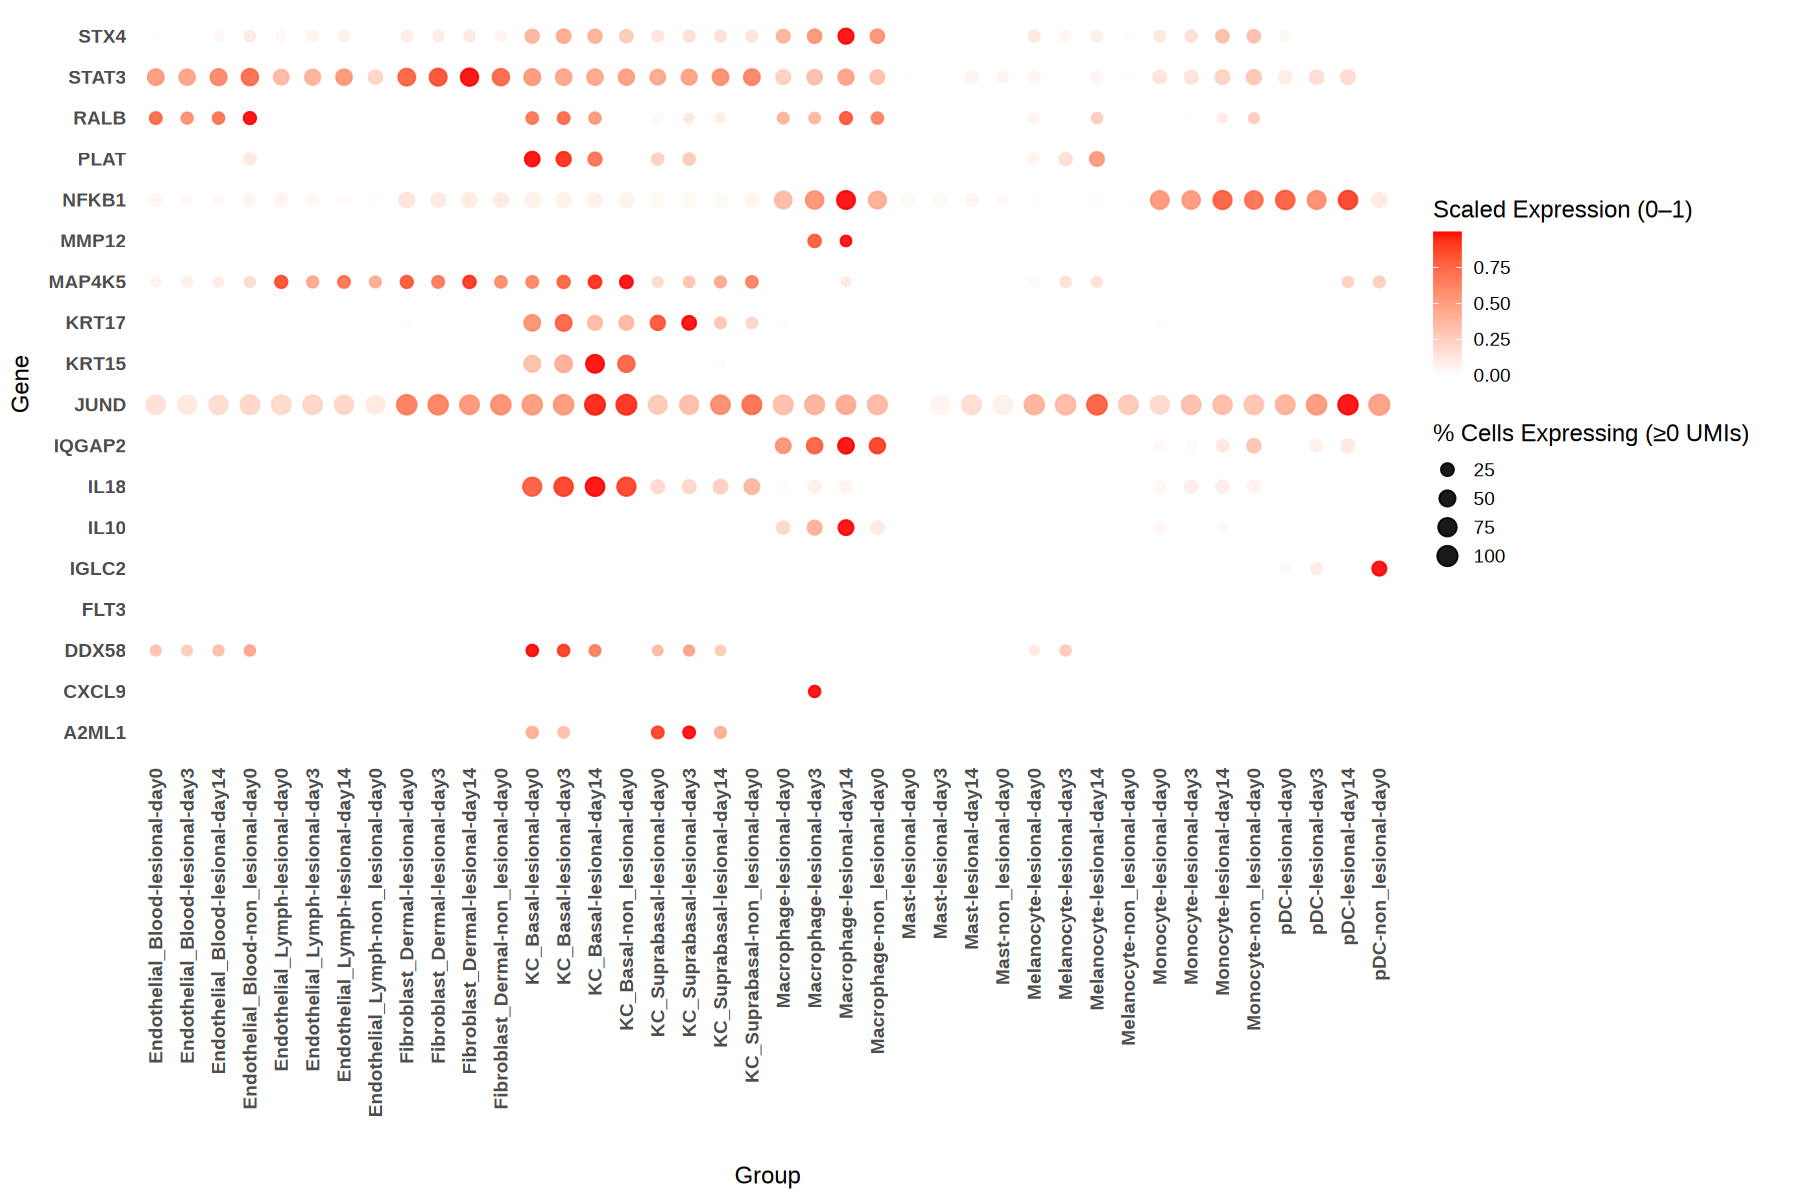

In [14]:

# ============================================================
# 1. Setup RNA assay and gene panel
# ============================================================
DefaultAssay(obj) <- "RNA"
obj <- JoinLayers(obj, assay = "RNA")   # ensures counts + data available

genes_treatment <- c(
    "BRAP","STX4","FLT3","NFKB1","DDX58","CXCL9","IGLC2","IQGAP2","IL18",
    "PRSS53","MMP12","SPAG1","SGSH","XCL1","MAP4K5","DKK4","RALB","PLAT",
    "TNFSF11","IL10","CTF1","CRYZ","A2ML1","STAT3","JUND","SPHK2","XCL2",
    "IL17","IL23","KRT17","KRT15"
)

genes_treatment <- intersect(genes_treatment, rownames(obj))
if(length(genes_treatment) == 0) stop("No genes from panel found in dataset.")

# ============================================================
# 2. Extract count + log-normalized matrices
# ============================================================
counts_mat <- GetAssayData(obj, slot="counts")[genes_treatment, , drop=FALSE]
data_mat   <- GetAssayData(obj, slot="data")[genes_treatment, , drop=FALSE]

meta <- obj@meta.data
meta$cell <- rownames(meta)

# ============================================================
# 3. Build long expression table
# ============================================================
expr_long <- tidyr::expand_grid(
    cell = meta$cell,
    Gene = genes_treatment
) %>%
    left_join(meta, by="cell") %>%
    mutate(
        Count = counts_mat[cbind(Gene, cell)],
        Data  = data_mat[cbind(Gene, cell)],
        Expr  = ifelse(Count > 0, 1, 0)   # ≥2 UMIs rule
    )

# ============================================================
# 4. Build summary table (celltype × site × day × gene)
# ============================================================
summary_table <- expr_long %>%
  group_by(paper_annotation, site, timepoint, Gene) %>%
  summarise(
      Total_Cells = n(),
      Cells_Pos   = sum(Expr),
      Percent     = round(100 * mean(Expr), 2),
      AvgExpr     = mean(Count),
      .groups = "drop"
  ) %>%
  mutate(
      Group = paste(paper_annotation, site, timepoint, sep="-")
  )


summary_table <- summary_table %>% filter(Percent >= 10)

# ============================================================
# 5. Scale AvgExpr to 0–1 per gene
# ============================================================
summary_table <- summary_table %>%
  group_by(Gene) %>%
  mutate(
      Scaled = (AvgExpr - min(AvgExpr)) / (max(AvgExpr) - min(AvgExpr) + 1e-9)
  ) %>%
  ungroup()


# -----------------------------------------------------------
# ORDER groups by: celltype → site → day0 → day3 → day14
# -----------------------------------------------------------
summary_table$timepoint <- factor(
    summary_table$timepoint,
    levels = c("day0", "day3", "day14")
)

ordered_groups <- summary_table %>%
  distinct(Group, paper_annotation, site, timepoint) %>%
  arrange(paper_annotation, site, timepoint) %>%
  pull(Group)

summary_table$Group <- factor(summary_table$Group, levels = ordered_groups)

# -----------------------------------------------------------
# FINAL DOT PLOT (labels removed)
# -----------------------------------------------------------
p <- ggplot(summary_table, aes(x = Group, y = Gene)) +
  geom_point(aes(
      size  = Percent,
      color = Scaled
  ), alpha = 0.9) +
  # removed geom_text(...) to remove labels
  scale_color_gradient(low="white", high="red") +
  scale_size(range=c(1.5, 5)) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(
        angle = 90, hjust = 1, vjust = 0.5, face="bold"
    ),
    axis.text.y = element_text(face="bold"),
    panel.grid = element_blank()
  ) +
  guides(
      color = guide_colorbar(title="Scaled Expression (0–1)"),
      size  = guide_legend(title="% Cells Expressing (≥0 UMIs)")
  )


# Save data used for the plot
write.csv(summary_table, "lesional_dotplot_data.csv", row.names = FALSE)

# Print & Save Plot
options(repr.plot.width = 15, repr.plot.height = 10)
print(p)

ggsave("lesional_dotplot_FINAL_clean.png", p, width=14, height=12, dpi=300)
ggsave("lesional_dotplot_FINAL_clean.pdf", p, width=14, height=12)



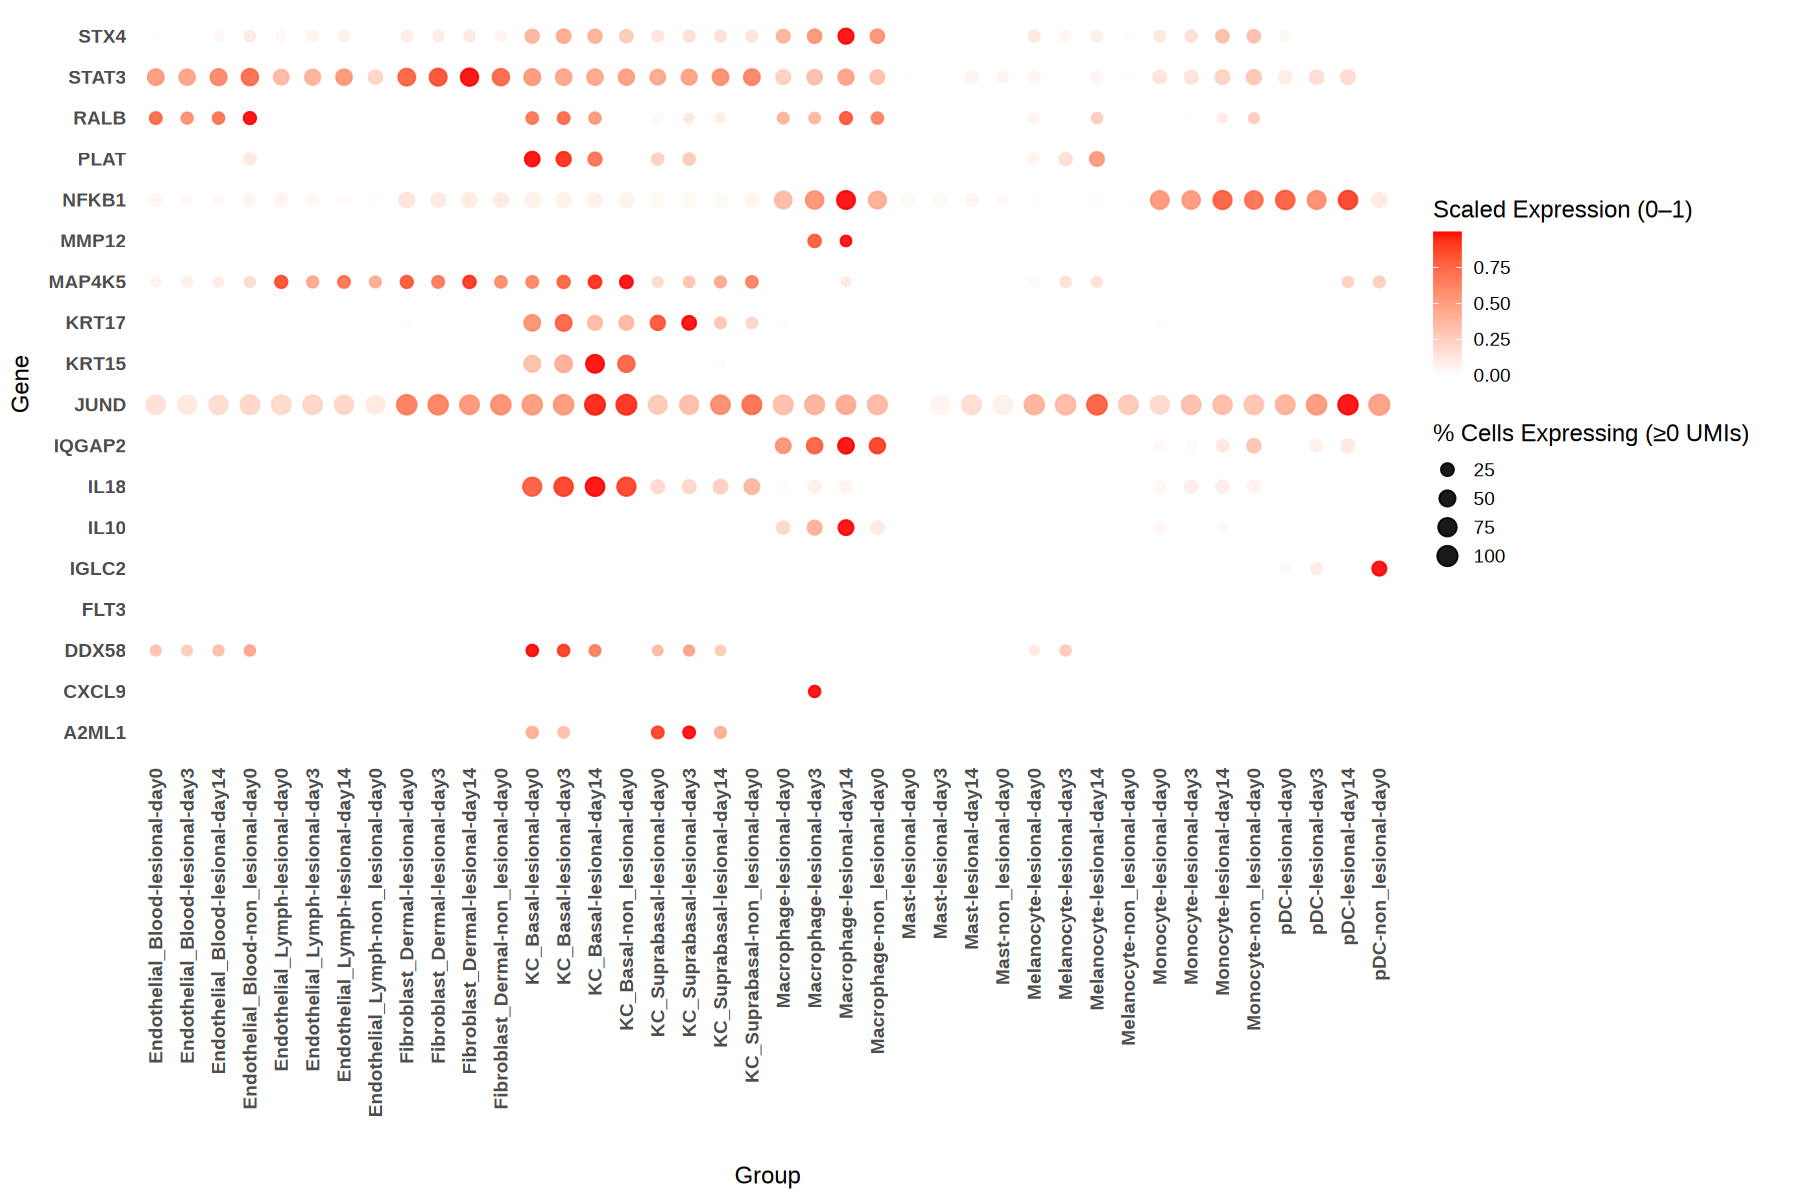

In [15]:
options(repr.plot.width = 15, repr.plot.height = 10)
print(p)


Processing cluster: Endothelial_Blood

Processing cluster: Endothelial_Lymph

Processing cluster: Fibroblast_Dermal

Processing cluster: KC_Basal

Processing cluster: KC_Suprabasal

Processing cluster: Macrophage

Processing cluster: Mast

Processing cluster: Melanocyte

Processing cluster: Monocyte

Processing cluster: pDC

DONE — Sign+magnitude color model applied.



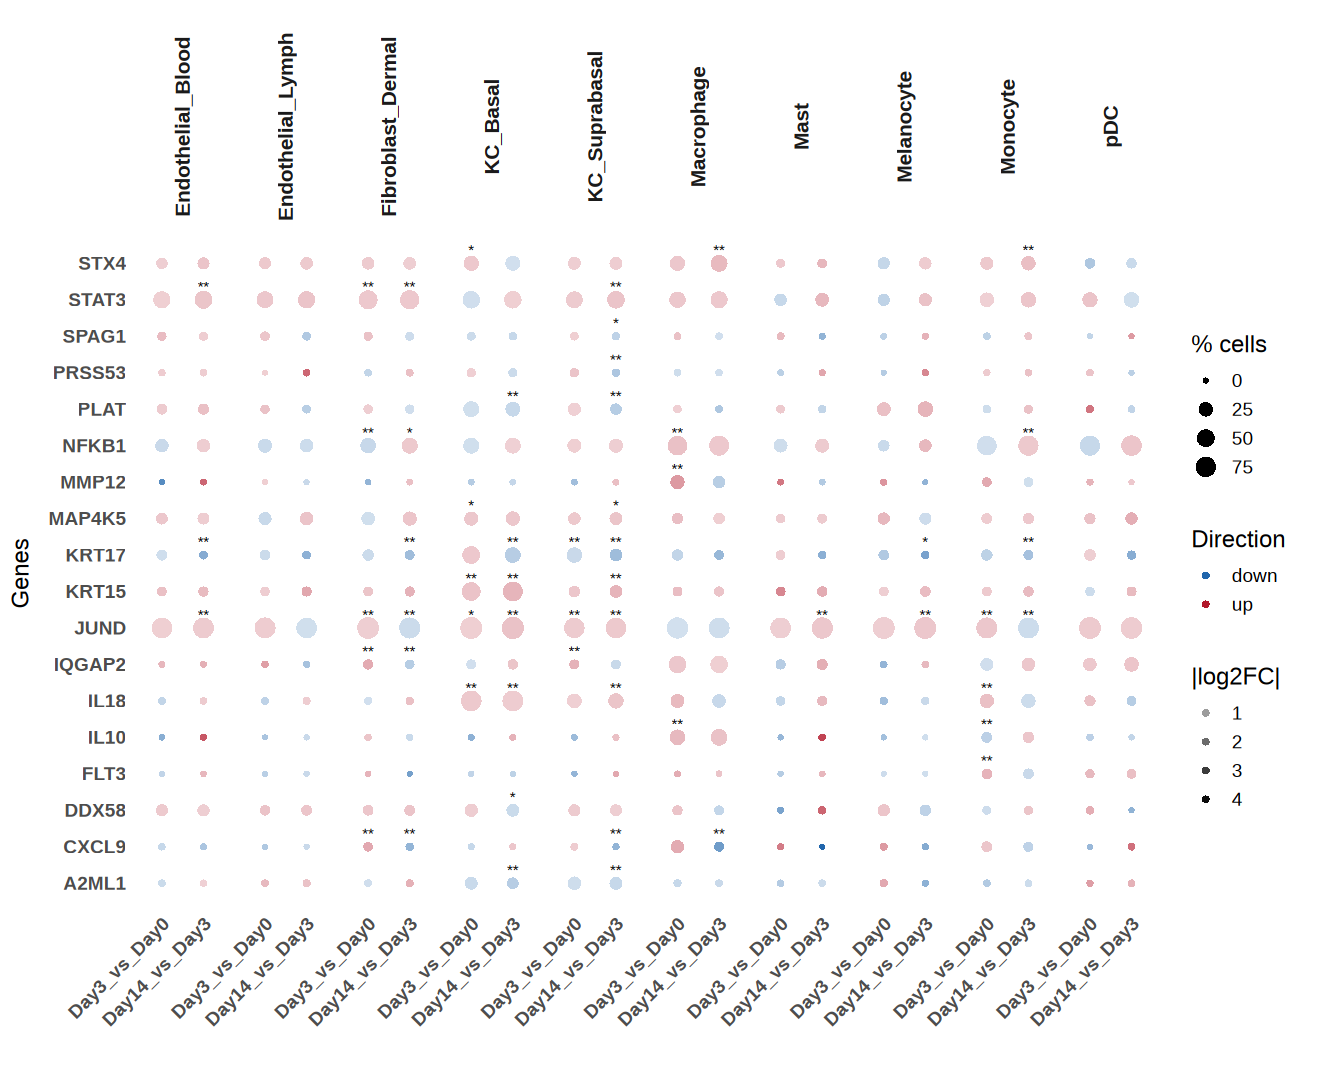

In [16]:

# ===========================================================
# 1. Use RNA assay
# ===========================================================
DefaultAssay(obj) <- "RNA"
obj <- JoinLayers(obj, assay = "RNA")

# ===========================================================
# 2. Gene list
# ===========================================================
genes <- c(
    "BRAP", "STX4", "FLT3", "NFKB1", "DDX58", "CXCL9", "IGLC2", "IQGAP2", "IL18",
    "PRSS53", "MMP12", "SPAG1", "SGSH", "XCL1", "MAP4K5", "DKK4", "RALB", "PLAT",
    "TNFSF11", "IL10", "CTF1", "CRYZ", "A2ML1", "STAT3", "JUND", "SPHK2", "XCL2",
    "IL17", "IL23", "KRT17", "KRT15"
)
genes <- intersect(genes, rownames(obj))

# ===========================================================
# 3. Keep lesional only
# ===========================================================
obj_L <- subset(obj, site == "lesional")

# ===========================================================
# 4. DE per cluster (cell type = paper_annotation)
# ===========================================================
results <- list()
clusters <- sort(unique(obj_L$paper_annotation))

for (ct in clusters) {
    message("Processing cluster: ", ct)

    sub <- subset(obj_L, paper_annotation == ct)
    if (ncol(sub) < 5) next

    Idents(sub) <- sub$timepoint

    # ---------- Day3 vs Day0 ----------
    if (all(c("day0", "day3") %in% levels(Idents(sub)))) {
        d3_d0 <- FindMarkers(sub,
            ident.1 = "day3", ident.2 = "day0",
            features = genes, logfc.threshold = 0, min.pct = 0
        )
        if (nrow(d3_d0) > 0) {
            d3_d0$gene <- rownames(d3_d0)
            d3_d0$comparison <- "Day3_vs_Day0"
            d3_d0$celltype <- ct
            d3_d0$timepoint <- "day3"
            results[[paste0(ct, "_d3_d0")]] <- d3_d0
        }
    }

    # ---------- Day14 vs Day3 ----------
    if (all(c("day3", "day14") %in% levels(Idents(sub)))) {
        d14_d3 <- FindMarkers(sub,
            ident.1 = "day14", ident.2 = "day3",
            features = genes, logfc.threshold = 0, min.pct = 0
        )
        if (nrow(d14_d3) > 0) {
            d14_d3$gene <- rownames(d14_d3)
            d14_d3$comparison <- "Day14_vs_Day3"
            d14_d3$celltype <- ct
            d14_d3$timepoint <- "day14"
            results[[paste0(ct, "_d14_d3")]] <- d14_d3
        }
    }
}

de_all <- bind_rows(results)

# ===========================================================
# 5. Significant genes + plotting fields
# ===========================================================
sig_genes <- unique(de_all$gene[de_all$p_val_adj < 0.05])
if (length(sig_genes) == 0) sig_genes <- unique(de_all$gene)

de_all <- de_all %>% filter(gene %in% sig_genes)

de_all <- de_all %>%
    mutate(
        logFC = avg_log2FC,
        neglog10_p = -log10(p_val_adj + 1e-300),
        signif = ifelse(p_val_adj < 0.01, "**",
            ifelse(p_val_adj < 0.05, "*", "")
        )
    )

# ===========================================================
# 6. Compute % expressing
# ===========================================================
meta <- obj_L@meta.data
meta$cell <- rownames(meta)

expr_mat <- GetAssayData(obj_L, slot = "data")[genes, , drop = FALSE]

percent_df_list <- list()

groups_df <- meta %>%
    select(cell, celltype = paper_annotation, timepoint) %>%
    group_by(celltype, timepoint) %>%
    summarise(cells = list(cell), .groups = "drop")

for (i in seq_len(nrow(groups_df))) {
    ct <- groups_df$celltype[i]
    tp <- groups_df$timepoint[i]
    cells <- intersect(groups_df$cells[[i]], colnames(expr_mat))

    if (length(cells) == 0) next

    perc <- rowMeans(expr_mat[, cells, drop = FALSE] > 0) * 100

    percent_df_list[[i]] <- data.frame(
        gene = names(perc),
        celltype = ct,
        timepoint = tp,
        PercentExpressing = perc
    )
}

percent_df <- bind_rows(percent_df_list)

# Merge
de_all <- left_join(
    de_all, percent_df,
    by = c("gene", "celltype", "timepoint")
)

de_all$PercentExpressing[is.na(de_all$PercentExpressing)] <- 0

# ===========================================================
#  FILTER: keep genes with ≥10% expressing AND |log2FC| ≥ 1.5
# ===========================================================


# ===========================================================
# 7. Save CSVs
# ===========================================================
write.csv(de_all, "DE_results_optionC.csv", row.names = FALSE)

cell_counts <- meta %>%
    group_by(paper_annotation, timepoint) %>%
    summarise(n_cells = n(), .groups = "drop") %>%
    rename(celltype = paper_annotation, day = timepoint)

write.csv(cell_counts, "cell_counts_lesional.csv", row.names = FALSE)

# ===========================================================
# 8. Option C DotPlot (ORDER FIXED + 45° rotation)
# ===========================================================
de_all$comparison <- factor(
    de_all$comparison,
    levels = c("Day3_vs_Day0", "Day14_vs_Day3") # <-- FIXED ORDER
) # ==========================================
# Create sign and magnitude for coloring
# ==========================================
de_all$logFC_sign <- ifelse(de_all$logFC > 0, "up", "down")
de_all$logFC_mag  <- abs(de_all$logFC)

# ==========================================
# Plot
# ==========================================
p <- ggplot(de_all, aes(x = comparison, y = gene)) +
    
    # POINTS: color = sign, alpha = magnitude
    geom_point(
        aes(
            color = logFC_sign,
            alpha = logFC_mag,
            size  = PercentExpressing
        ),
        stroke = 0,
        shape = 16
    ) +
    
    # **STAR MARKERS (Significance)**
    geom_text(aes(label = signif),
              color = "black", size = 3, vjust = -0.8) +

    # ==========================================
    # MANUAL COLOUR SCALE (NO MIDPOINT)
    # ==========================================
    scale_color_manual(
        values = c(
            "up"   = "#b2182b",  # dark red
            "down" = "#2166ac"   # dark blue
        ),
        name = "Direction"
    ) +

    # Alpha shows |log2FC|
    scale_alpha_continuous(
        range = c(0.2, 1),
        name  = "|log2FC|"
    ) +

    # Dot size = % cells expressing
    scale_size(range = c(1.5, 6), name = "% cells") +

    facet_wrap(~celltype, nrow = 1) +
    
    theme_minimal(base_size = 14) +
    theme(
        strip.text = element_text(size = 12, face = "bold", angle = 90),
        axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
        axis.text.y = element_text(face = "bold"),
        panel.grid = element_blank()
    ) +
    
    labs(x = "", y = "Genes")

# Jupyter Notebook size
options(repr.plot.width = 11, repr.plot.height = 9)
print(p)

# Save
ggsave("DE_optionC_dotplot.png", p, width = 11, height = 15, dpi = 300)
ggsave("DE_optionC_dotplot.pdf", p, width = 11, height = 15)

message("DONE — Sign+magnitude color model applied.")